The dataset required for the tasks can be found here:

http://busibud.com/ml_tasks.zip



For this task, we would prefer if you worked on a notebook format for all of the tasks you need to undertake, including data cleaning, transformation, numerical simulation, statistical modeling, data visualization, machine learning, etc. Please make sure it is as expressive as possible.



Task

Here you would need to create a model which assigns a customer to a certain customer category based on the total value of orders they’ve placed. This would let us target the most valuable customers with certain offers which promote a higher spend.

The dataset is a CSV, where each row represents an sku which is a part of an order. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

Content
InvoiceNo
A single invoice number represents one order that was placed. There might be multiple rows for the same invoice number, representing the different SKUs that were ordered.


StockCode
This represents the sku for the particular item that was ordered.


Description
This describes the exact item that was ordered in words.


Quantity
The quantity of the specific sku that was ordered.


InvoiceDate
This is the date the order was placed.


UnitPrice
This is the price of the particular sku that was ordered.


CustomerID
An anonymized ID of the customer who placed the order.

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor,XGBClassifier   #xgboost package is required
from category_encoders.ordinal import OrdinalEncoder  #category_encoders package is required
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV  # sklearn package required

## loading the data and understand it.

In [2]:
Xdata = pd.read_csv(r"C:\Users\shiva\job_practice\ml_tasks\ml_tasks\ml_task_1\data.csv")

In [3]:
Xdata.shape

(541909, 8)

In [4]:
Xdata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# function to check missing columns in the dataset
def find_missing(Xdata):
    """
    Xdata: dataframe
    return sorted missing values columns of given dataset.
    """ 
    from IPython.display import display
    missing_values_columns = [[col,Xdata[col].isnull().sum(),Xdata[col].dtypes] for col in Xdata.columns if Xdata[col].isnull().any()]
    display(sorted(missing_values_columns, key=(lambda k:k[1])),len(missing_values_columns))
    
# convert Invoice date into 4 different features 
def date_to_features(df,c_n):
    """
    df: dataframe
    c_n: column name of datetime type
    
    """
    df['Invoice_Year'] = pd.to_datetime(df[c_n]).dt.year
    df['Invoice_month'] = pd.to_datetime(df[c_n]).dt.month
    df['Invoice_day'] = pd.to_datetime(df[c_n]).dt.day
    df['Invoice_time'] = pd.to_datetime(df[c_n]).dt.time

In [6]:
find_missing(Xdata)

[['Description', 1454, dtype('O')], ['CustomerID', 135080, dtype('float64')]]

2

In [7]:
Xdata.UnitPrice.min(),Xdata.UnitPrice.max()  # check value range of CustomerID

(-11062.06, 38970.0)

### Some information about the dataset we found are
1. Dataset has 541909 rows 
2. InvoiceNo feature has 25900 unique entries and 3710 unique entries when CustomerID null.
3. StockCode feature has 4070 unique entries means total 4070 items in stock

    3.1 StockCode startwith digit only help in our problem others are charges or discount or various fees as given in description
    
4. Description feature has 4223 unique entries meaning 1 stockcode may have different description: ex: white or cream product have same stockcode
5. Qunatity feature has values from -80995 to 80995

    5.1 There are 5172 Invoices with negative values has corresponding 1589 CustomersId ( excluding null)
    
    5.2 Total of 2559 type of stocks but (as StockCode and description mentioned) negative quantity represents
    
        5.1.1 Discounts, Postage, Amazonfee, Samples, Bank Charges, Manual, CRUK Commission etc(delete these rows).
        5.2.2 negative also represent items returned. 

6. InvoiceDate range from 2010/12/01 to 2011/12/09(YYYY-MM-DD)
7. UnitPrice Range (-11062.06, 38970.0)

    7.1 **Some UnitPrie feature have 0 values delete those rows because they don't play a role in our output**
    
    7.2 **Negative UnitPrice mentioned in description is bad debt and no CustomerId so delete those rows also**
    
8. CustomerID has total 4373 unique numbers range between 12346-18287 (excluding null values)


### Data cleaning :

1. As mentioned in 5.1.1 delete stockcode not starting with digit
2. As mentioned in 7.1 and 7.2 delete less than or equal to zero UnitPrice cells.
3. 

NOTE: As we just have to categorise our customer based on total value of orders they’ve placed, important features for us are only 


In [8]:
# follow point 5.1.1
Xdata = Xdata[Xdata.StockCode.str[0].str.isdigit()]

In [9]:
# follow point 7.1 and 7.2
Less_equal_UnitPrice = Xdata.loc[Xdata.UnitPrice<=0].index
Xdata = Xdata.drop(labels=Less_equal_UnitPrice)

In [10]:
#convert Invoice date into datetime format
Xdata.InvoiceDate = pd.to_datetime(Xdata.InvoiceDate,format="%m%d%Y %H:%M",infer_datetime_format=True)

### handling missing values

1. No need to deal with Null value of Description feature, already handled with our data cleaning. 
1. CustomerID has 131553 null values remaining
    1.1 either we remove all the rows with null value.
    1.2 or we can predict CustomerID using other features. (XGBoost algo is used for this)


In [11]:
Customer_id_null = Xdata.loc[Xdata.CustomerID.isnull()==True].index
Xdata_train = Xdata.drop(labels=Customer_id_null)
Xdata_test = Xdata.loc[Xdata.CustomerID.isnull()==True]

In [12]:
Xdata_train = Xdata_train.reset_index(drop=True)
Xdata_test = Xdata_test.reset_index(drop=True)

In [13]:
# to check weather our predicted value of customer id are out of range or not
customer_id = set(Xdata_train.CustomerID)

### data transformation 

1. convert Invoice date into 4 different features which helps in categorization of customer and finding null value of CustomerID
2. apply label encoding on categorical features.

Note: drop InvoiceDate feature because too many categories only used for forcasting of sales not good for customer categorization

In [14]:
date_to_features(Xdata_train,"InvoiceDate")
date_to_features(Xdata_test,"InvoiceDate")

In [15]:
Xdata_train = Xdata_train.drop(labels="InvoiceDate",axis=1)
Xdata_test = Xdata_test.drop(labels="InvoiceDate",axis=1)

In [16]:
cat_feature = ["InvoiceNo","StockCode","Description","Country","Invoice_Year","Invoice_month","Invoice_day","Invoice_time"]

In [17]:
cat_encoder = OrdinalEncoder(cols=cat_feature)
labeled_Xdata_train = cat_encoder.fit_transform(Xdata_train)
labeled_Xdata_test = cat_encoder.transform(Xdata_test)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(labeled_Xdata_train.drop(labels="CustomerID",axis=1),
                                                  labeled_Xdata_train.CustomerID,
                                                  test_size=0.25, 
                                                  random_state=42
                                                 )

### Pricipal component analysis can be applied to reduce dimensionality

In [262]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_train)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,3463.633746,2539.034327,-55.516287,-2.111241,287.359294,-0.737741,-1.360503,5.037146,-0.063912,-0.086561
1,-3702.623366,-204.889861,-52.050716,4.919023,150.100235,10.363885,0.927675,-0.815625,-0.521076,0.064105
2,-225.787050,2705.509301,-40.558451,4.003827,-208.202511,2.812136,-2.151248,-0.616276,-0.357611,-0.050284
3,-6076.744973,-1636.407883,-36.636819,8.010042,202.078369,13.056258,-0.759592,-0.781003,-0.371692,0.114151
4,-6020.683263,794.585119,-78.987221,6.376452,-181.609613,10.026136,-2.034307,-0.566054,-0.433868,0.080756


In [263]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_train.columns,  # and the rows are the original features
)

In [264]:
def plot_variance(pca, width=10, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.05)
    )
    # Set up figure
    fig.set(figwidth=10, dpi=100)
    return axs

<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

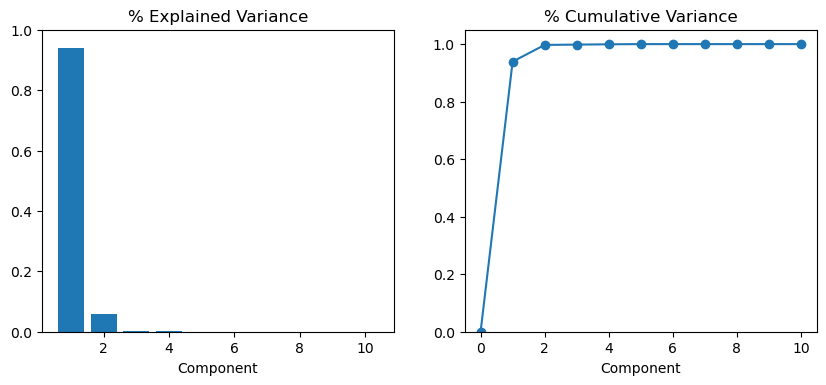

In [265]:
plot_variance(pca)

From above graph we can see that PC1 and PC2 both can be done a good job and treat as 2 feature dataset to find CustomerID

we can ensemble of our 10 featured and this as a single method for prediction of CustomerID

In [83]:
xgboost_custmorID = XGBRegressor(n_estimators=400,learning_rate=0.1,early_stopping_rounds=10,eval_metric='rmse',random_state=34,n_jobs=4,)
# xgboost_custmorID = XGBClassifier()

In [50]:
# grid = { 
#     'n_estimators': [100,200,300,400,500],
#     'max_features': ['sqrt', 'log2'],
#     'learning_rate': [0.1,0.2,0.3],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy'],
#     'random_state' : [18]
# }
# rf_cv = GridSearchCV(estimator=xgboost_custmorID, param_grid=grid)
# rf_cv.fit(X_train, y_train)
# rf_cv.best_params_

In [75]:
# scores = -1 * cross_val_score(xgboost_custmorID, X_train, y_train,scoring='accuracy',cv=5,fit_params={'eval_set': [(X_val, y_val)],'verbose':False})
# print("Mean cross-validation score: %.2f" % scores.mean())

In [85]:
xgboost_custmorID.fit(X=X_train,y=y_train, eval_set=[(X_val, y_val)],verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=34,
             reg_alpha=0, reg_lambda=1, ...)

In [86]:
predict = xgboost_custmorID.predict(X_val)

TypeError: only size-1 arrays can be converted to Python scalars